# LSTM을 이용한 로이터 뉴스 카테고리 분류

In [1]:
import numpy as np
import tensorflow as tf

seed = 2021
np.random.seed(seed)
tf.random.set_seed(seed)

In [2]:
from tensorflow.keras.datasets import reuters
(X_train, y_train), (X_test, y_test) = reuters.load_data(num_words=None, test_split=0.2)

2113536/2110848 [==============================] - 0s 0us/step


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/reuters.py:148: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/reuters.py:149: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_test, y_test = np.array(xs[idx:]), np.array(labels[idx:])


In [3]:
# 데이터 확인
category = np.max(y_train) + 1
print(category, '카테고리')
print(len(X_train), len(X_test))

46 카테고리
8982 2246


In [4]:
# 첫번째 뉴스기사
print(X_train[0])

[1, 27595, 28842, 8, 43, 10, 447, 5, 25, 207, 270, 5, 3095, 111, 16, 369, 186, 90, 67, 7, 89, 5, 19, 102, 6, 19, 124, 15, 90, 67, 84, 22, 482, 26, 7, 48, 4, 49, 8, 864, 39, 209, 154, 6, 151, 6, 83, 11, 15, 22, 155, 11, 15, 7, 48, 9, 4579, 1005, 504, 6, 258, 6, 272, 11, 15, 22, 134, 44, 11, 15, 16, 8, 197, 1245, 90, 67, 52, 29, 209, 30, 32, 132, 6, 109, 15, 17, 12]


In [5]:
reuters.get_word_index()['the']

557056/550378 [==============================] - 0s 0us/step


1

In [6]:
index_dict = {}
for key, value in reuters.get_word_index().items():
    index_dict[value] = key
len(index_dict)

30979

In [7]:
index_dict[1]

'the'

In [8]:
# 첫번째 뉴스 복원
text = ''
for x in X_train[0]:
    text += index_dict[x] + ' '
text

'the wattie nondiscriminatory mln loss for plc said at only ended said commonwealth could 1 traders now april 0 a after said from 1985 and from foreign 000 april 0 prices its account year a but in this mln home an states earlier and rise and revs vs 000 its 16 vs 000 a but 3 psbr oils several and shareholders and dividend vs 000 its all 4 vs 000 1 mln agreed largely april 0 are 2 states will billion total and against 000 pct dlrs '

In [9]:
# 파이썬스러운 코드
' '.join(index_dict[x] for x in X_train[0])

'the wattie nondiscriminatory mln loss for plc said at only ended said commonwealth could 1 traders now april 0 a after said from 1985 and from foreign 000 april 0 prices its account year a but in this mln home an states earlier and rise and revs vs 000 its 16 vs 000 a but 3 psbr oils several and shareholders and dividend vs 000 its all 4 vs 000 1 mln agreed largely april 0 are 2 states will billion total and against 000 pct dlrs'

In [10]:
# 뉴스 기사의 최대 길이
max(len(x) for x in X_train)

2376

In [11]:
# 뉴스 기사의 평균 길이
sum(map(len, X_train)) / len(X_train)

145.5398574927633

In [12]:
# 뉴스 카테고리 분포
unique_elements, count_elements = np.unique(y_train, return_counts=True)
unique_elements

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45])

In [13]:
count_elements

array([  55,  432,   74, 3159, 1949,   17,   48,   16,  139,  101,  124,
        390,   49,  172,   26,   20,  444,   39,   66,  549,  269,  100,
         15,   41,   62,   92,   24,   15,   48,   19,   45,   39,   32,
         11,   50,   10,   49,   19,   19,   24,   36,   30,   13,   21,
         12,   18])

In [14]:
label_count = dict(zip(unique_elements, count_elements))
label_count
print(label_count)

{0: 55, 1: 432, 2: 74, 3: 3159, 4: 1949, 5: 17, 6: 48, 7: 16, 8: 139, 9: 101, 10: 124, 11: 390, 12: 49, 13: 172, 14: 26, 15: 20, 16: 444, 17: 39, 18: 66, 19: 549, 20: 269, 21: 100, 22: 15, 23: 41, 24: 62, 25: 92, 26: 24, 27: 15, 28: 48, 29: 19, 30: 45, 31: 39, 32: 32, 33: 11, 34: 50, 35: 10, 36: 49, 37: 19, 38: 19, 39: 24, 40: 36, 41: 30, 42: 13, 43: 21, 44: 12, 45: 18}


### LSTM으로 로이터 뉴스 분류하기
- 빈도수 3,000까지 (총 단어수 : 30,979)
- 단어 140 (최대 2,376 단어)

In [15]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, LSTM, Embedding
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [16]:
# 빈도수 3,000
(X_train, y_train), (X_test, y_test) = reuters.load_data(num_words=3000, test_split=0.2)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/reuters.py:148: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/reuters.py:149: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_test, y_test = np.array(xs[idx:]), np.array(labels[idx:])


In [17]:
# 문장당 단어 수 140
max_len = 140
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

In [18]:
# One-hot encoding
Y_train = to_categorical(y_train)
Y_test = to_categorical(y_test)

In [19]:
# Model 정의
model = Sequential([
    Embedding(3000, 120),
    LSTM(120)                ,
    Dense(46, activation='softmax')
    
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 120)         360000    
_________________________________________________________________
lstm (LSTM)                  (None, 120)               115680    
_________________________________________________________________
dense (Dense)                (None, 46)                5566      
Total params: 481,246
Trainable params: 481,246
Non-trainable params: 0
_________________________________________________________________


In [28]:
# 모델설정
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [29]:
# Callback 함수 정의
model_path = 'reuter-best-lstm.hdf5'
checkpoint = ModelCheckpoint(model_path, monitor='val_loss', verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

In [30]:
# 모델학습
history = model.fit(X_train, Y_train, batch_size=100, epochs=50,
                    validation_split=0.2, verbose=2,
                    callbacks=[checkpoint,early_stopping])

Epoch 1/50
72/72 - 34s - loss: 2.6490 - accuracy: 0.3545 - val_loss: 2.4211 - val_accuracy: 0.3450

Epoch 00001: val_loss improved from inf to 2.42112, saving model to reuter-best-lstm.hdf5
Epoch 2/50
72/72 - 1s - loss: 2.1789 - accuracy: 0.4409 - val_loss: 1.9641 - val_accuracy: 0.4797

Epoch 00002: val_loss improved from 2.42112 to 1.96414, saving model to reuter-best-lstm.hdf5
Epoch 3/50
72/72 - 1s - loss: 1.7864 - accuracy: 0.5365 - val_loss: 1.7017 - val_accuracy: 0.5559

Epoch 00003: val_loss improved from 1.96414 to 1.70169, saving model to reuter-best-lstm.hdf5
Epoch 4/50
72/72 - 1s - loss: 1.6471 - accuracy: 0.5841 - val_loss: 1.7257 - val_accuracy: 0.5671

Epoch 00004: val_loss did not improve from 1.70169
Epoch 5/50
72/72 - 1s - loss: 1.5840 - accuracy: 0.6010 - val_loss: 1.6124 - val_accuracy: 0.5927

Epoch 00005: val_loss improved from 1.70169 to 1.61242, saving model to reuter-best-lstm.hdf5
Epoch 6/50
72/72 - 1s - loss: 1.5035 - accuracy: 0.6110 - val_loss: 1.5155 - val_

In [32]:
best_model = load_model(model_path)
_, acc = best_model.evaluate(X_test, Y_test)
print(f'Accuracy: {acc:.4f}')

71/71 [==============================] - 1s 7ms/step - loss: 1.4287 - accuracy: 0.6545
Accuracy: 0.6545


### 훈련과정 시각화

In [33]:
import matplotlib.pyplot as plt 
%matplotlib inline

In [34]:
# 학습셋
y_acc = history.history['accuracy']
y_loss = history.history['loss']
# 검증셋
y_vacc = history.history['val_accuracy']
y_vloss = history.history['val_loss']

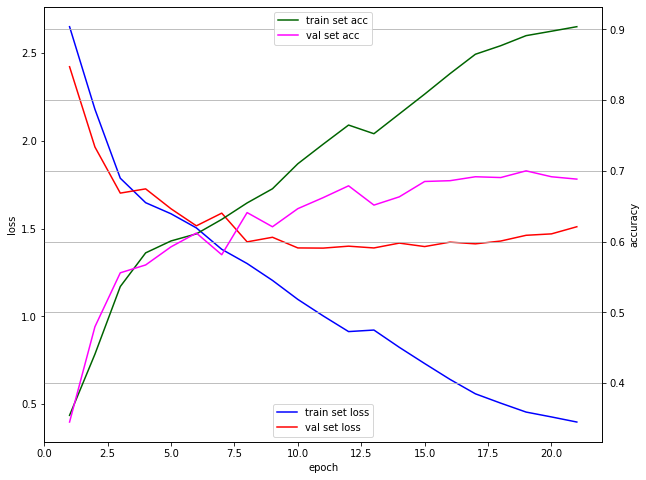

In [35]:
x_len = np.arange(1, len(y_loss)+1)
fig, ax0 = plt.subplots(figsize=(10,8))
ax1 = ax0.twinx()
ax0.plot(x_len, y_loss, c="blue", label='train set loss')
ax0.plot(x_len, y_vloss, c="red", label='val set loss')
ax0.set_ylabel('loss')
ax1.plot(x_len, y_acc, c="darkgreen", label='train set acc')
ax1.plot(x_len, y_vacc, c="magenta", label='val set acc')
ax1.set_ylabel('accuracy')
ax0.set_xlabel('epoch')
ax0.legend(loc='lower center')
ax1.legend(loc='upper center')
plt.grid()
plt.show()